<a href="https://colab.research.google.com/github/bb2796/sample-repo/blob/main/PRML%EF%BC%93%E7%AB%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np


class PolynomialFeatures(object):

    def __init__(self, degree):
        assert type(degree) is int, "%s is not int" % type(degree)
        self.degree = degree

    def transform(self, x):
        features = [x ** i for i in range(self.degree + 1)]
        return np.array(features).transpose()

In [2]:
class BayesianRegression(object):

    def __init__(self, alpha=1., beta=1.):
        self.alpha = alpha
        self.beta = beta

    def fit(self, X, t):
        #3.54
        self.w_var = np.linalg.inv(
            self.alpha * np.identity(np.size(X, 1))
            + self.beta * X.T.dot(X))
        
        #3.53
        self.w_mean = self.beta * self.w_var.dot(X.T.dot(t))

    def predict(self, X):
        return X.dot(self.w_mean)

    def predict_dist(self, X):
        y = X.dot(self.w_mean)
        #3.59
        y_var = 1 / self.beta + np.sum(X.dot(self.w_var) * X, axis=1)
        y_std = np.sqrt(y_var)
        return y, y_std

In [17]:
class EvidenceApproximation(BayesianRegression):

    def __init__(self, iter_max=100, alpha=1., beta=1.):
        self.iter_max = iter_max
        self.alpha = alpha
        self.beta = beta

    def fit(self, X, t):
        M = X.T.dot(X)
        #固有値を計算
        eigenvalues = np.linalg.eigvalsh(M)
        for i in range(self.iter_max):
            params = [self.alpha, self.beta]
            #親クラスのメソッドを継承
            super(EvidenceApproximation, self).fit(X, t)
            #3.91
            self.gamma = np.sum(self.beta * eigenvalues / (self.alpha + self.beta * eigenvalues))
            #3.92
            self.alpha = self.gamma / self.w_mean.dot(self.w_mean)
            print("alpha{}".format(self.alpha))
            #3.95
            self.beta = (len(t) - self.gamma) / np.sum((t - X.dot(self.w_mean)) ** 2)
            print("beta{}".format(self.beta))
            #２つの行列が等しいか判定
            if np.allclose(params, [self.alpha, self.beta]):
                break
        super(EvidenceApproximation, self).fit(X, t)

    def evidence(self, X, t):
        M = X.T.dot(X)
        #3.86
        return (len(M) * np.log(self.alpha)
                + len(t) * np.log(self.beta)
                - self.beta * np.sum((t - X.dot(self.w_mean)) ** 2)
                - np.linalg.slogdet(self.alpha + self.beta * M)[1])

In [18]:
def create_toy_data(func, low=0, high=1, size=10, sigma=1.):
    x = np.random.uniform(low, high, size)
    t = func(x) + np.random.normal(scale=sigma, size=size)
    return x, t

def func(x):
    return x * (x - 5) * (x + 5)

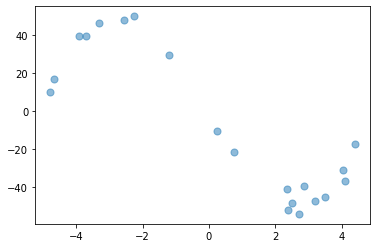

In [19]:
x, t = create_toy_data(func, low=-5, high=5, size=20, sigma=5.)
plt.scatter(x, t, s=50, alpha=0.5, label="observation")

0
alpha0.015484826135755182
beta0.0006617243121567196
alpha0.03200250580228995
beta0.0006697002404618966
alpha0.049983775363980514
beta0.000668968864216823
alpha0.0698422000566626
beta0.0006679629720934368
alpha0.09184713099675734
beta0.0006671548950449002
alpha0.11626145719027763
beta0.0006665334744635494
alpha0.14336518198634224
beta0.0006660516475235113
alpha0.17346422545511184
beta0.0006656716957523818
alpha0.20689589605473366
beta0.0006653669479088098
alpha0.24403353449390222
beta0.0006651187829416976
alpha0.28529109811443465
beta0.000664914031498901
alpha0.3311279924068132
beta0.0006647431975181692
alpha0.382054307930895
beta0.0006645992937943096
alpha0.43863656822819636
beta0.0006644770794333149
alpha0.5015040758631416
beta0.0006643725534502655
alpha0.5713559392962867
beta0.0006642826122440067
alpha0.6489688654082009
beta0.0006642048134242241
alpha0.7352058081649268
beta0.0006641372098976993
alpha0.8310255718828546
beta0.0006640782312384845
alpha0.9374934772809882
beta0.00066402

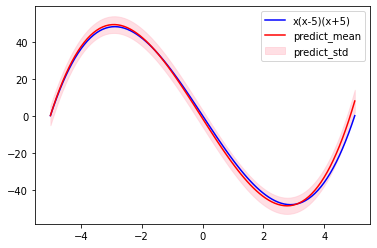

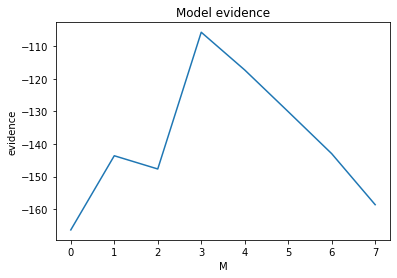

In [21]:
evidences = []
regressions = []
alpha = []
beta = []
for i in range(8):
    print(i)
    features = PolynomialFeatures(degree=i)
    X = features.transform(x)
    regression = EvidenceApproximation(alpha=100., beta=100.)
    regression.fit(X, t)
    evidences.append(regression.evidence(X, t))
    regressions.append(regression)
degree = np.argmax(evidences)
regression = regressions[degree]

x_test = np.linspace(-5, 5, 100)
X_test = PolynomialFeatures(degree=int(degree)).transform(x_test)
y, y_std = regression.predict_dist(X_test)

plt.plot(x_test, func(x_test), color="blue", label="x(x-5)(x+5)")
plt.plot(x_test, y, color="red", label="predict_mean")
plt.fill_between(x_test, y - y_std, y + y_std, color="pink", alpha=0.5, label="predict_std")
plt.legend()
plt.show()

plt.plot(evidences)
plt.title("Model evidence")
plt.xlabel("M")
plt.ylabel("evidence")
plt.show()

In [8]:
degree

3